### Домашнее задание к вебинару 5
  
1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ  
2. Обучить модель на выбор из segmentation_models_pytorch

In [1]:
import os

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn

from glob import glob #находит все пути по шаблону
from PIL import Image
import cv2



In [2]:
# Изучим файл CSV
data_csv = pd.read_csv('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/list.csv')

In [3]:
data_csv.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png


In [4]:
IMG_PATH = '../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p'
MASK_PATH = '../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask'

imgs_paths = sorted([i for i in Path(IMG_PATH).glob('*.jpg')])
masks_paths = sorted([i for i in Path(MASK_PATH).glob('*.png')])

imgs_paths[3], masks_paths[:3]

(PosixPath('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00000004.jpg'),
 [PosixPath('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00000001.png'),
  PosixPath('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00000002.png'),
  PosixPath('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00000003.png')])

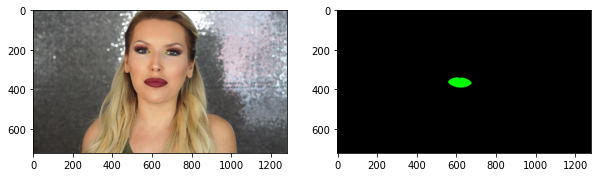

(720, 1280, 3)


In [5]:
fig, ax = plt.subplots(1,2, figsize = (10,10))

ax[0].imshow(Image.open(imgs_paths[1]))
ax[1].imshow(Image.open(masks_paths[1]))

plt.show()
print(np.array(Image.open(imgs_paths[1])).shape)

In [6]:
len(imgs_paths), len(masks_paths), len(data_csv)

(28594, 28540, 28594)

Количество изображений и масок не совпадает! Масок больше, но соответствующих изображений нет. Уберем лишние маски

In [7]:
data = data_csv.loc[data_csv['mask'].isin([i.name for i in masks_paths])]

In [8]:
data.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png


Создадим класс кастомного датасета

In [9]:
SIZE = 256
class MakeupLipsDataset(Dataset):
    
    def __init__(self, data, preprocessing=None):
        self.data = data

        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        img_path = os.path.join(IMG_PATH, data['filename'])
        mask_path = os.path.join(MASK_PATH, data['mask'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = np.array(img).astype('float')
        
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_RGB2BGR)
        mask = cv2.resize(mask, (SIZE, SIZE))
        mask = np.array(mask).astype('float')
        
#         img = Image.open(img_path)
#         img = img.resize((256, 256))
#         img = np.asarray(img).astype('float')    
    
#         mask = Image.open(mask_path)
#         mask = mask.resize((256, 256))
#         mask = np.asarray(mask).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
             
        else:
            img = torch.as_tensor(img) / 255.0
    
       
        mask = torch.as_tensor(mask)/255.0
        
        img = img.permute(2,0,1)
        mask = mask.permute(2,0,1)

        
        return (img.float(), mask) #s)
    
    def __len__(self):
        return self.data_len

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


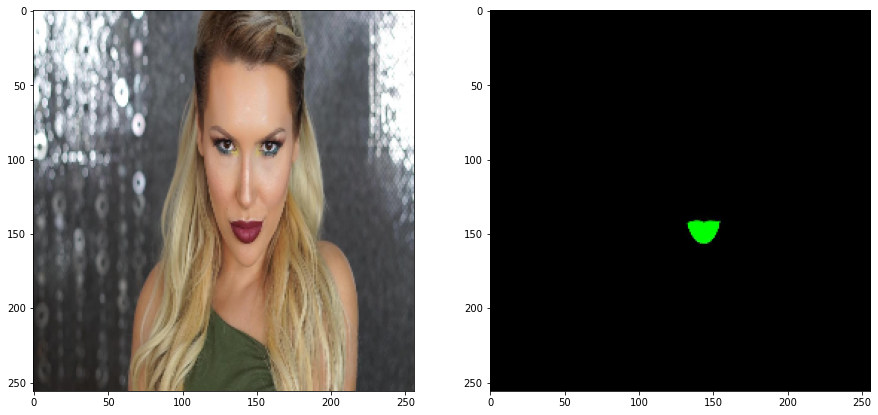

In [10]:
# Проверим работу класса датасет
lipsdataset = MakeupLipsDataset(data)
img, masks = lipsdataset[0]
print(img.shape, masks.shape)


fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Создадим модель**

In [12]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 725 kB/s            
     |████████████████████████████████| 58 kB 1.8 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 376 kB 2.8 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=c4ee9ab084dad44a7a8539bef809542d4423c1e2e7b1d3096ef75fc917a3cd5e
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0a5c2a5101bcd2090a53fa8680c4d91ef04c34d614d57cac98ec4bae634e001a
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [13]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'resnet34'
segm_model = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [14]:
# Инициализируем датасет для тренировочных и тестовых данных
X_train, X_valid =  train_test_split(data, test_size=0.33 ,random_state=1)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = MakeupLipsDataset(X_train, preprocessing=preprocess_input)
valid_data = MakeupLipsDataset(X_valid, preprocessing=preprocess_input)

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])
tensor(-2.0494) tensor(2.5703)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


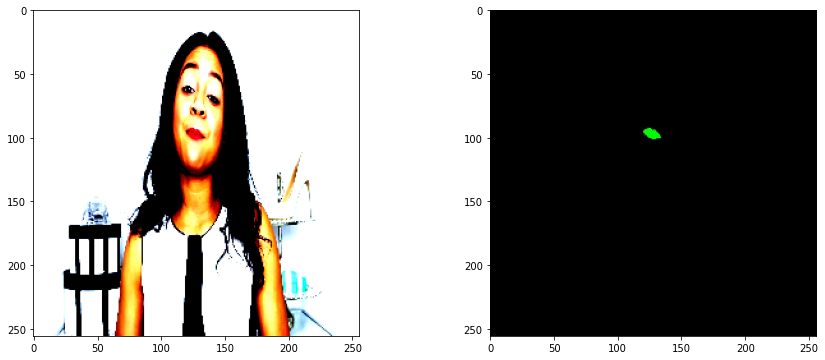

In [16]:
for img, mask in train_loader:
    print(img.shape, mask.shape)
    print(img[0].min(), img[0].max())
    print(mask[0].min(), mask[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(mask[0].permute(1, 2, 0))
    break

In [17]:
# Определим функцию потерь и оптимизатор

criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segm_model.parameters(), lr=0.001)

In [18]:
# Создадим одну эпоху обучения

train_epoch = smp.utils.train.TrainEpoch(
    segm_model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segm_model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [19]:
epochs = 7
max_score = 0
unet_train_iou = []
unet_valid_iou = []

for epoch in range(0, epochs):

    print(f'Epoch: {epoch + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    unet_train_iou.append(train_logs['iou_score'])
    unet_valid_iou.append(valid_logs['iou_score'])

Epoch: 1
valid: 100%|██████████| 2355/2355 [08:15<00:00,  4.75it/s, dice_loss - 0.03646, iou_score - 0.9319]
Epoch: 2
valid: 100%|██████████| 2355/2355 [05:41<00:00,  6.89it/s, dice_loss - 0.03262, iou_score - 0.9378]
Epoch: 3
valid: 100%|██████████| 2355/2355 [05:44<00:00,  6.84it/s, dice_loss - 0.0308, iou_score - 0.941]
Epoch: 4
valid: 100%|██████████| 2355/2355 [05:39<00:00,  6.94it/s, dice_loss - 0.03348, iou_score - 0.9362]
Epoch: 5
valid: 100%|██████████| 2355/2355 [05:38<00:00,  6.96it/s, dice_loss - 0.02903, iou_score - 0.9441]
Epoch: 6
valid: 100%|██████████| 2355/2355 [05:40<00:00,  6.93it/s, dice_loss - 0.02911, iou_score - 0.944]
Epoch: 7
valid: 100%|██████████| 2355/2355 [05:34<00:00,  7.04it/s, dice_loss - 0.03163, iou_score - 0.9394]


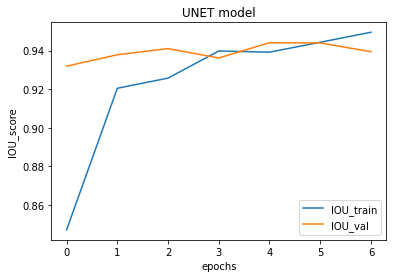

In [20]:
# визуализация метрик 

plt.plot(unet_train_iou,label='IOU_train')
plt.plot(unet_valid_iou, label='IOU_val')

plt.title(f"UNET model")   
plt.ylabel('IOU_score')   
plt.xlabel('epochs')   
plt.legend()
plt.show()

In [21]:
# делаем предсказание
data_iter = iter(valid_loader)
images, masks = data_iter.next()
images, masks = images.to(device), masks.to(device)

outputs = segm_model(images)

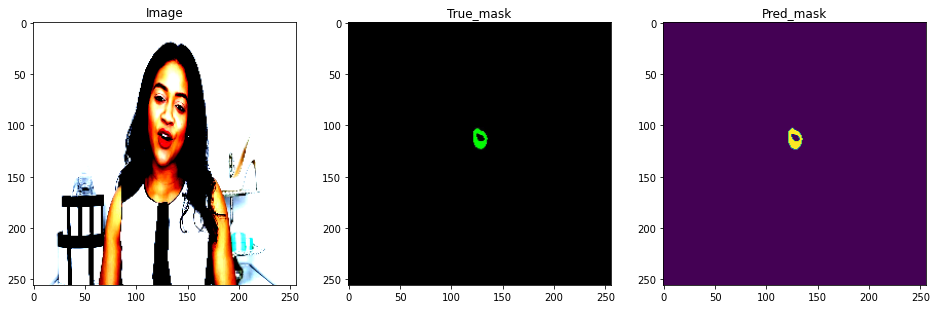

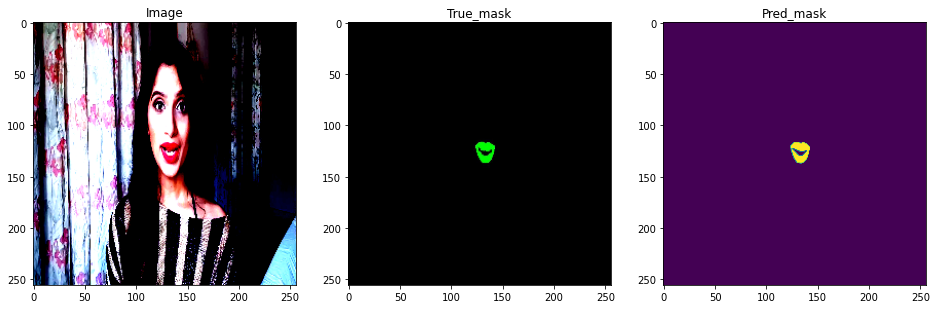

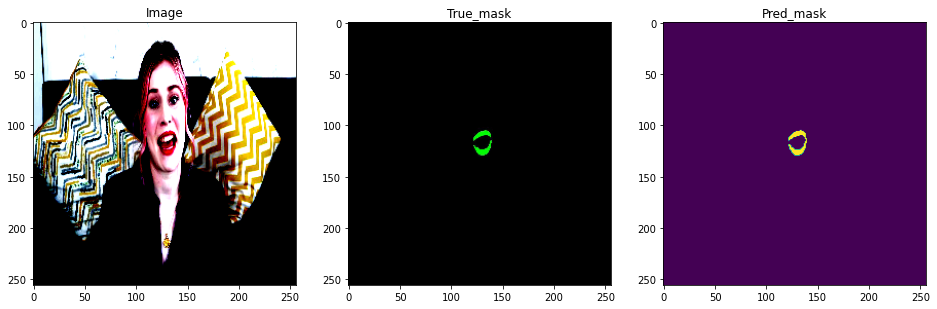

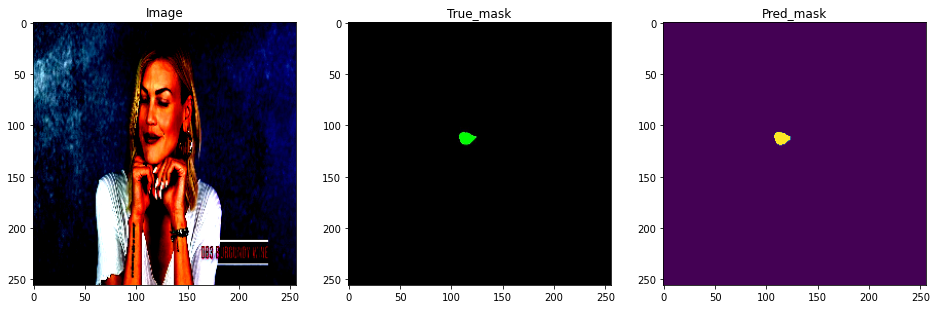

In [22]:
# визуализация
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(masks[i].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')